In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
#importing project created functions, these can be found in model_prep folder in repo
from model_prep import Xy_prep_all, Xy_prep_silence, Xy_prep_music, cross_val_time

In [4]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:64634" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:64653, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:64659, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:64656, threads: 2>})

# Random Forest OBO

In [147]:
rf = RandomForestRegressor(verbose=True)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xf, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished


In [148]:
par_scores = {'par':[],'pred':[], 'true':[],'MAPE':[]}
for par in range(30,36):
    mask = test_y.reset_index(drop=True)['PID']==par
    test_X = test_Xf.loc[mask]
    y_pred = rf.predict(test_X)
    y_true = test_y.loc[test_y['PID']==par, 'target_1_sec'].to_numpy()
    par_scores['par'].append(par)
    par_scores['pred'].append(y_pred)
    par_scores['true'].append(y_true)
    
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    par_scores['MAPE'].append(MAPE)
    r2 = rf.score(y_true, y_pred)

par_scores_df = pd.DataFrame(par_scores)   
par_scores_df[['par', 'MAPE']]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


,par,MAPE
0,30,0.274355
1,31,0.352939
2,32,0.422114
3,33,0.326676
4,34,0.301685
5,35,0.311196


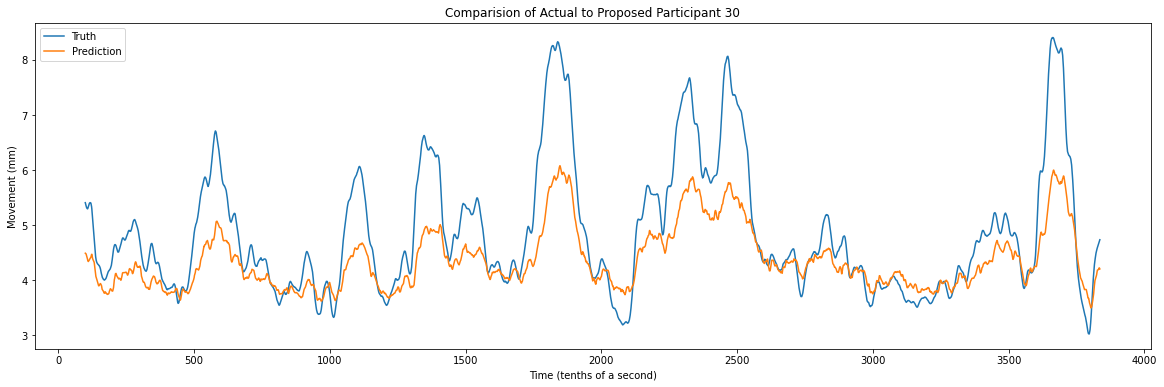

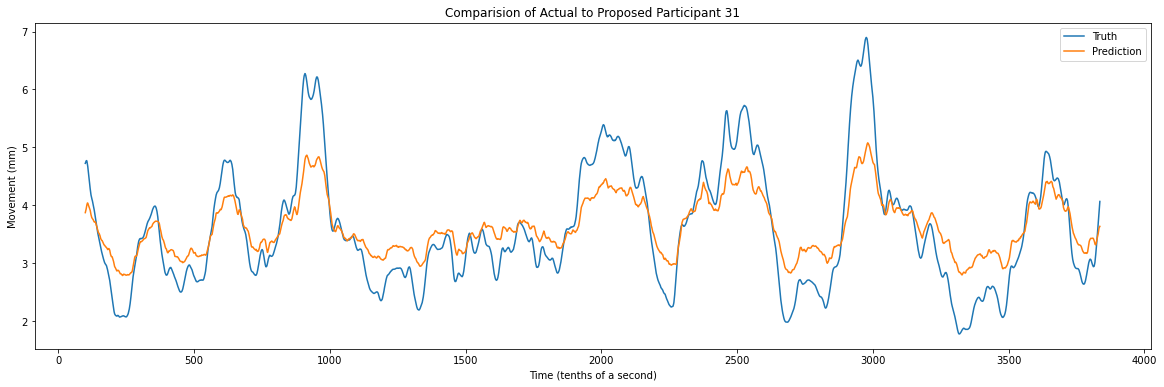

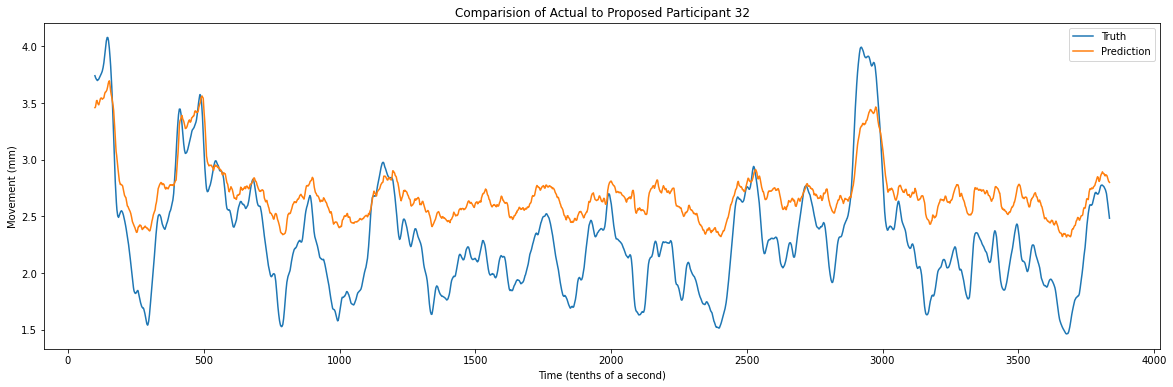

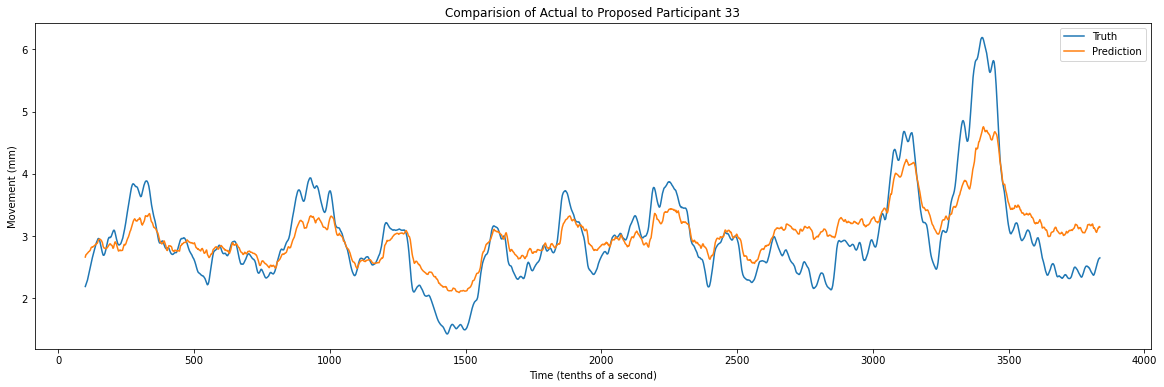

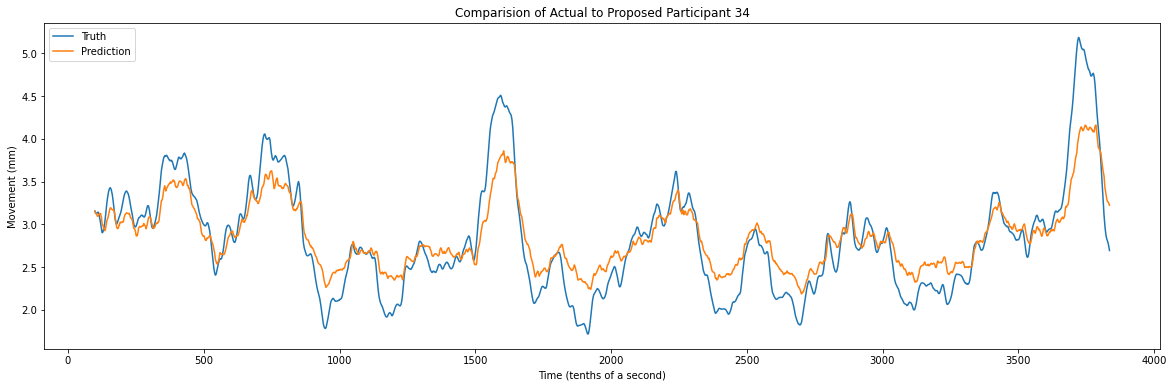

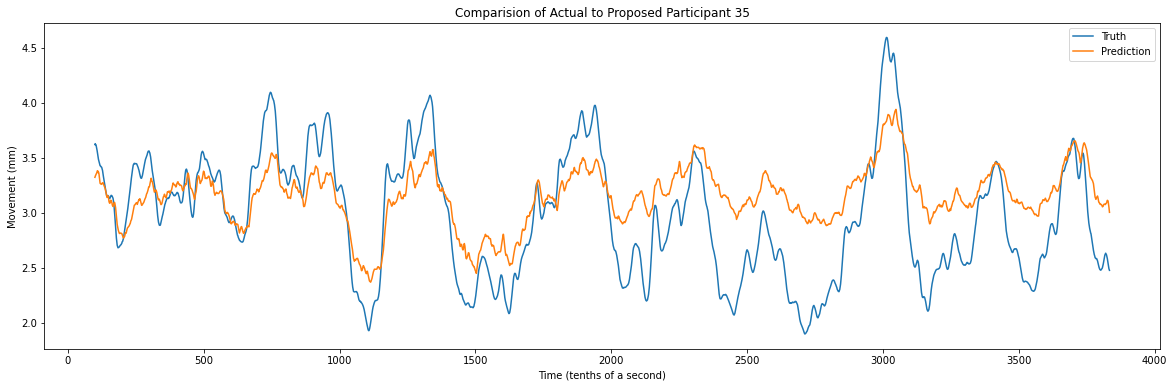

In [153]:
ind = 0
for par in range(30,36):
    prediction = par_scores_df.loc[par_scores_df['par']==par, 'pred'][ind]
    truth = par_scores_df.loc[par_scores_df['par']==par, 'true'][ind]
    compare = pd.DataFrame({'Truth':truth, 'Prediction':prediction})
    compare.rolling(100).mean().plot(figsize=(20, 6))
    plt.title('Comparision of Actual to Proposed Participant {}'.format(par))
    plt.xlabel('Time (tenths of a second)')
    plt.ylabel('Movement (mm)')
    plt.show()
    ind +=1

# Random Forest 50 estimators, all participants split test size about 25%

In [162]:
train_X, test_X, train_y, test_y = Xy_prep_all(model_data, 'target_1_sec', 
                                                                             train_a=0, train_b=55, test_a=56, test_b=75)

In [163]:
train_Xct = CT.fit_transform(train_X)
    
#transform test data based on training fit
test_Xct = CT.transform(test_X)

#get columns names from ColumnTransformer
cols = get_feature_name(CT)
train_Xf = pd.DataFrame(train_Xct, columns=cols)
cols = get_feature_name(CT)
test_Xf = pd.DataFrame(test_Xct, columns=cols)

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.2s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.1s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


<ipython-input-31-8740127314b0>:32: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [164]:
rf = RandomForestRegressor(n_estimators=50, verbose=True)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xf, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 32.6min finished


In [167]:
test_y['PID'].unique()

array([71, 74, 63, 64, 61, 65, 59, 72, 73, 62, 70, 58, 60, 67, 57, 68, 69,
       66], dtype=int64)

In [169]:
par_scores = {'par':[],'pred':[], 'true':[],'MAPE':[]}
for par in test_y['PID'].unique():
    print(par)
    mask = test_y.reset_index(drop=True)['PID']==par
    test_X = test_Xf.loc[mask]
    y_pred = rf.predict(test_X)
    y_true = test_y.loc[test_y['PID']==par, 'target_1_sec'].to_numpy()
    par_scores['par'].append(par)
    par_scores['pred'].append(y_pred)
    par_scores['true'].append(y_true)
    
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    par_scores['MAPE'].append(MAPE)
    #r2 = rf.score(y_true, y_pred)

par_scores_df = pd.DataFrame(par_scores)   
par_scores_df[['par', 'MAPE']]

71
74


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


63
64


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


61
65
59


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


72
73


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


62
70
58


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


60
67


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


57
68
69


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


66


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


,par,MAPE
0,71,0.317174
1,74,0.375571
2,63,0.367146
3,64,0.428666
4,61,0.346065
5,65,0.323626
6,59,0.283930
7,72,0.403321
8,73,0.289198
9,62,0.301196


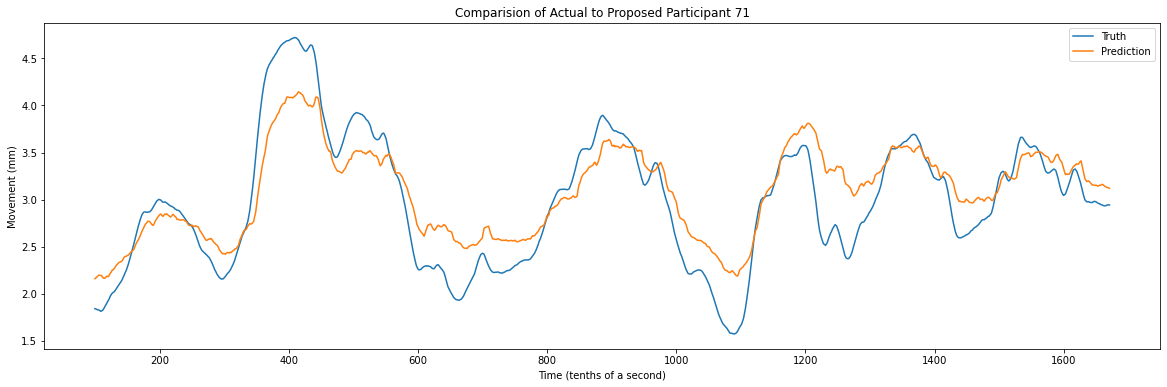

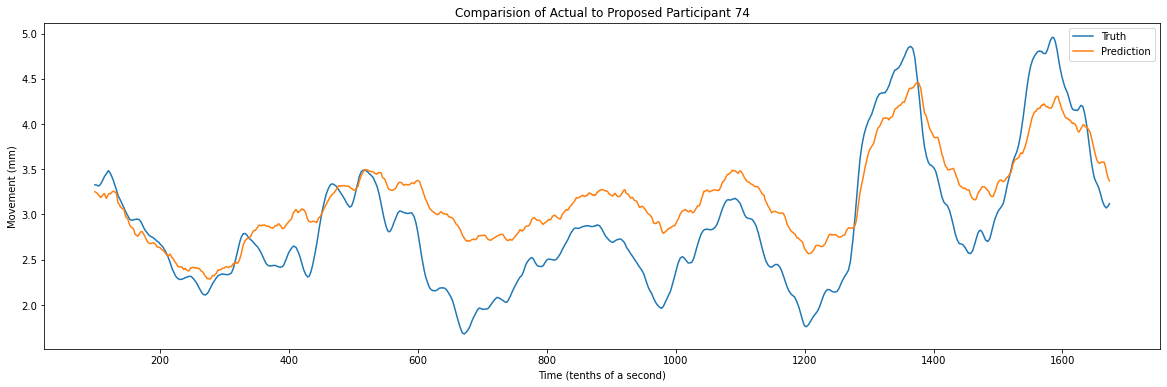

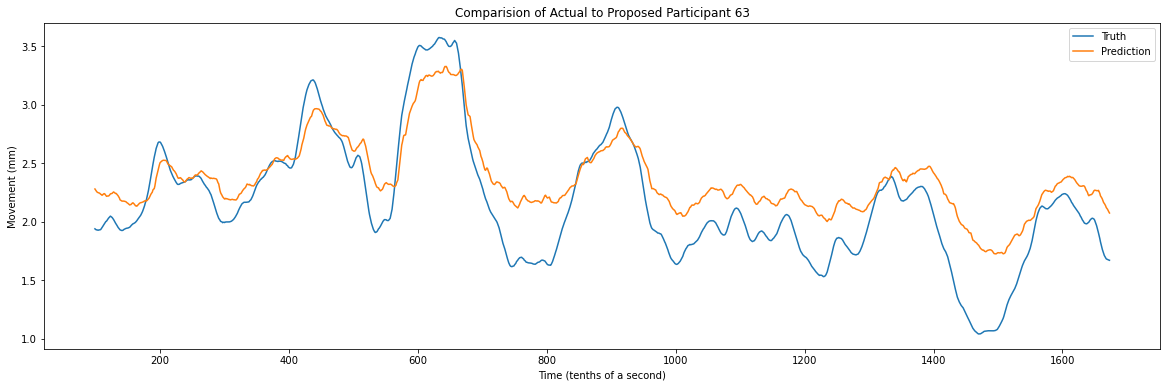

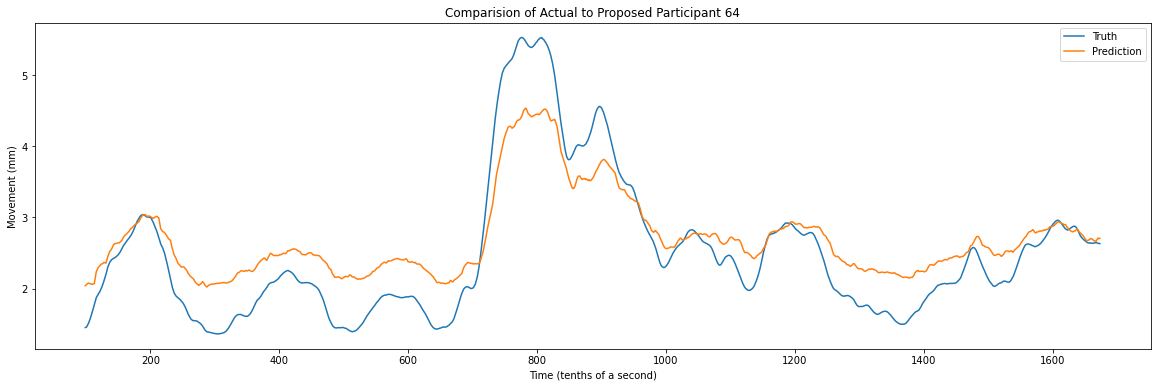

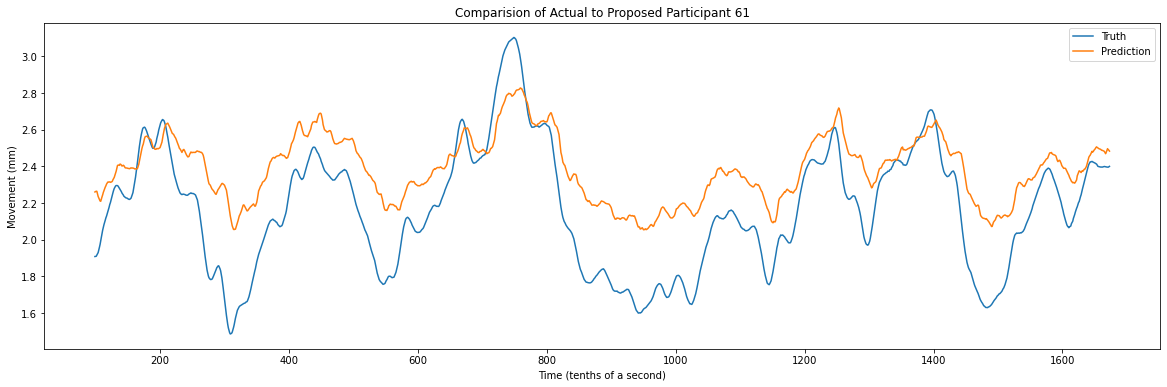

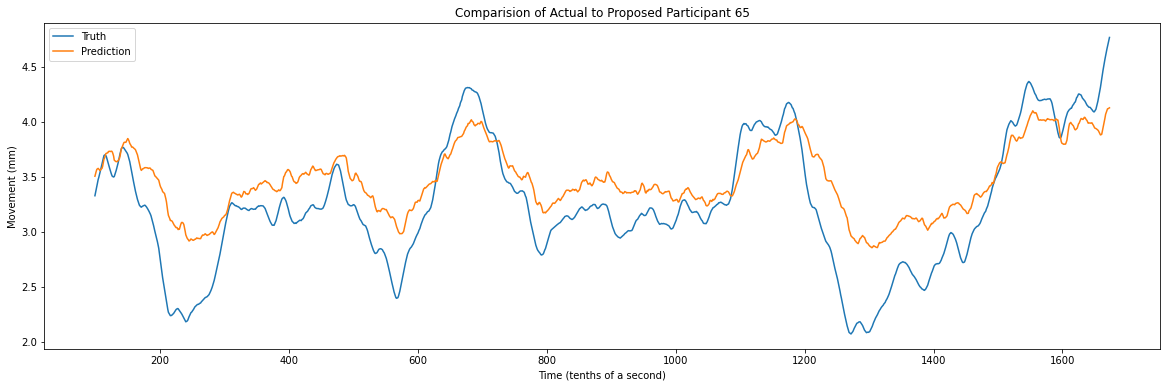

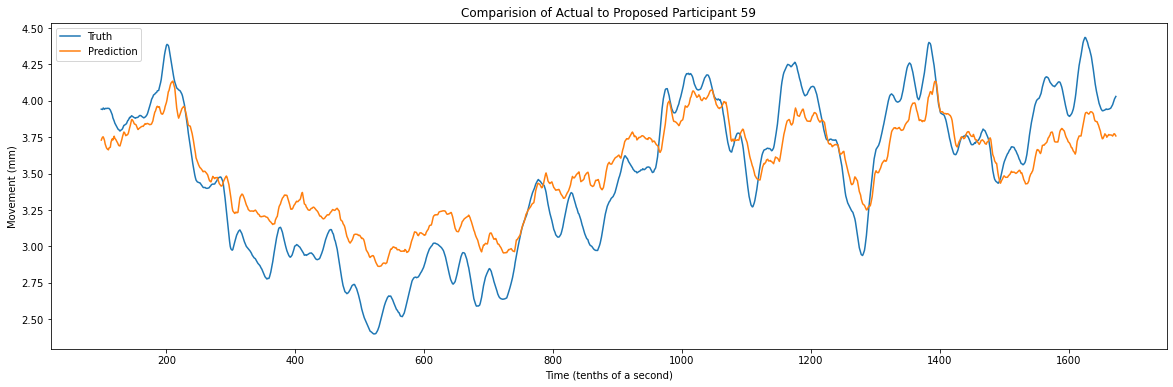

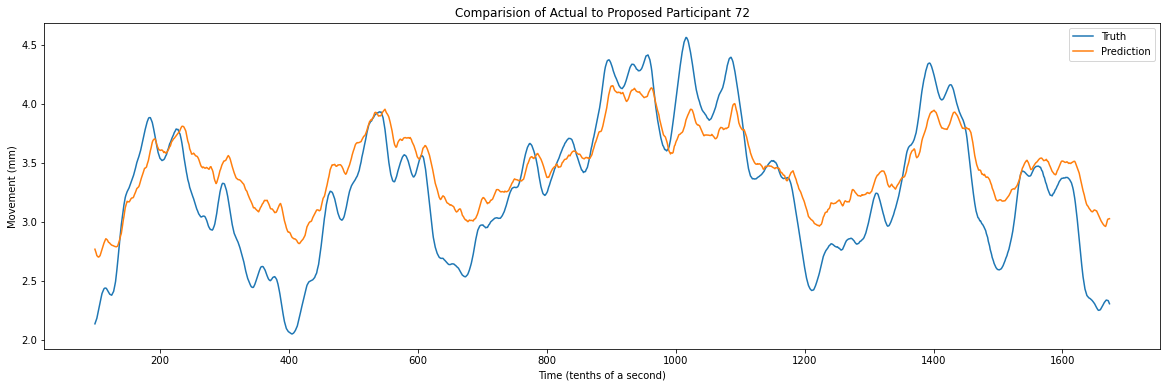

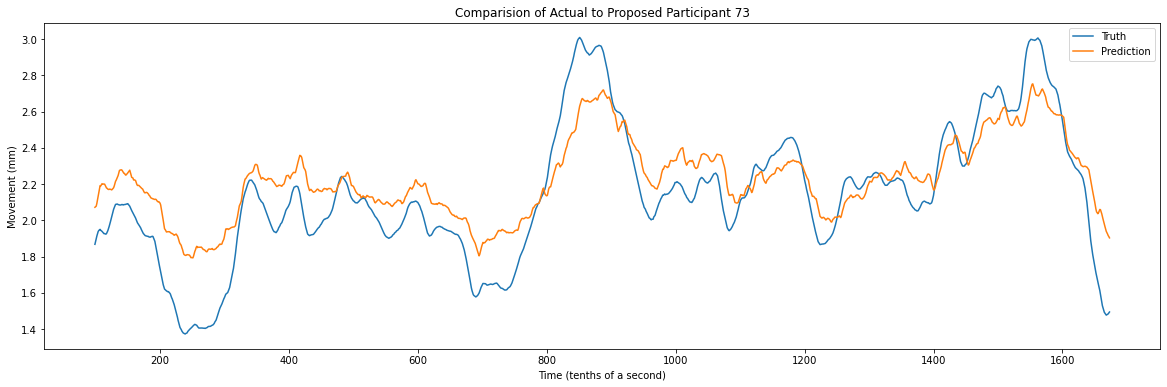

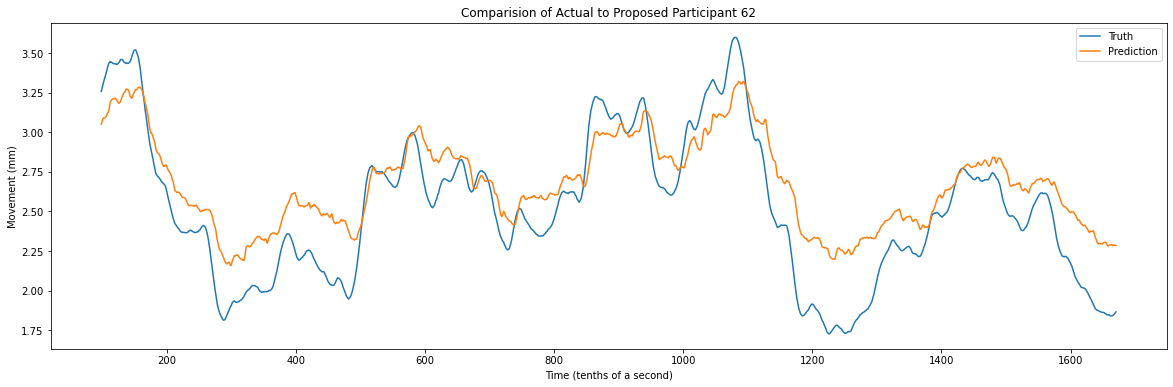

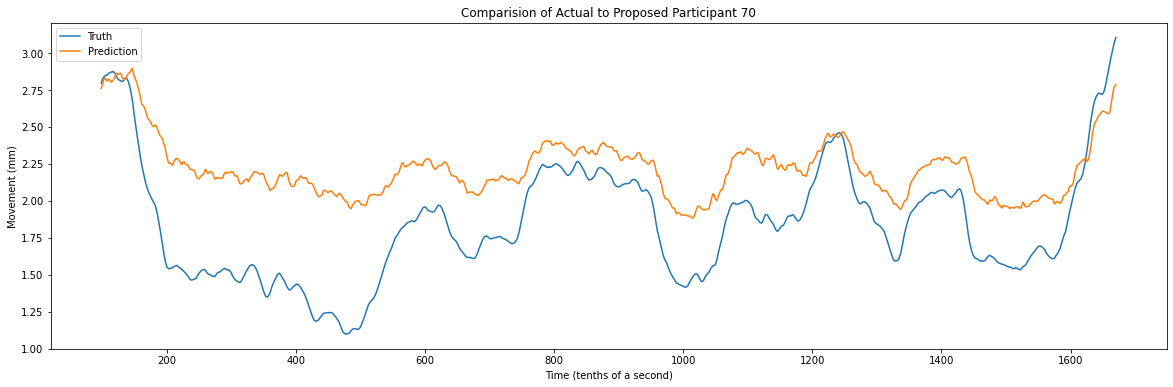

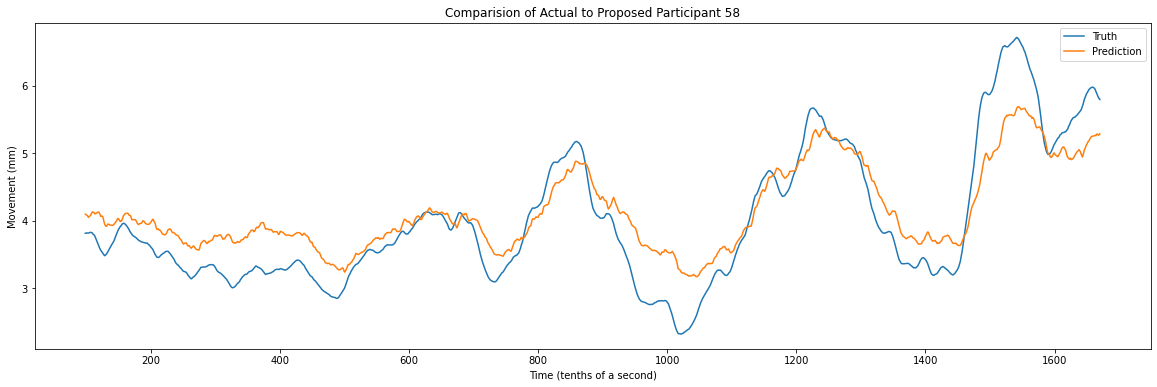

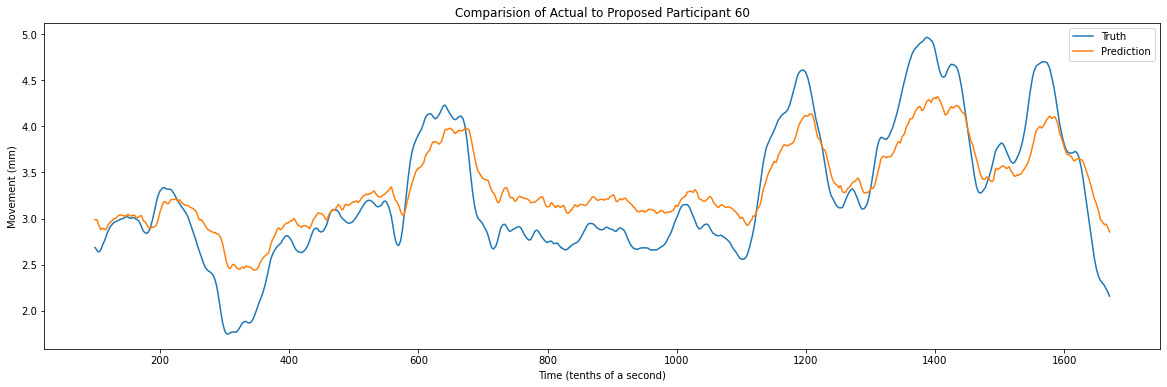

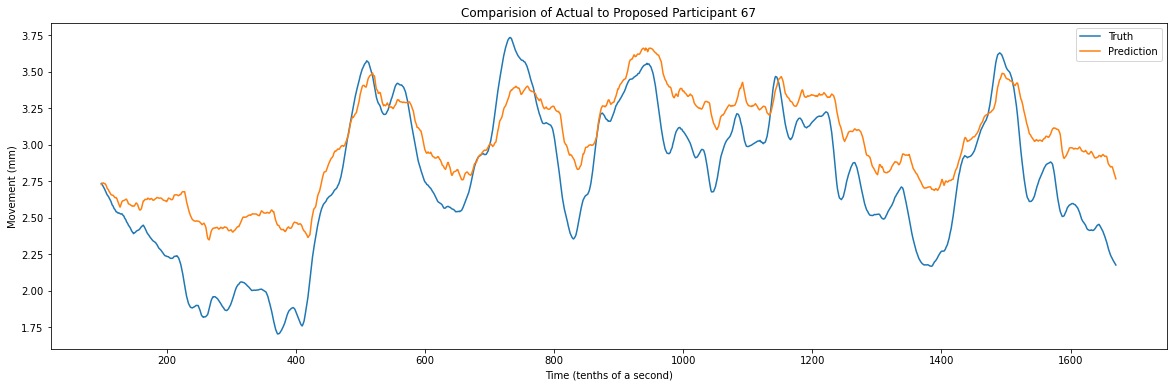

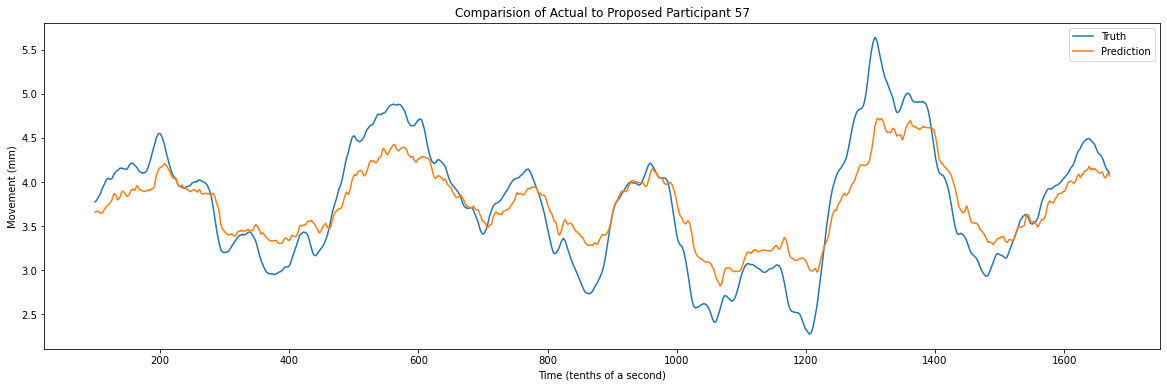

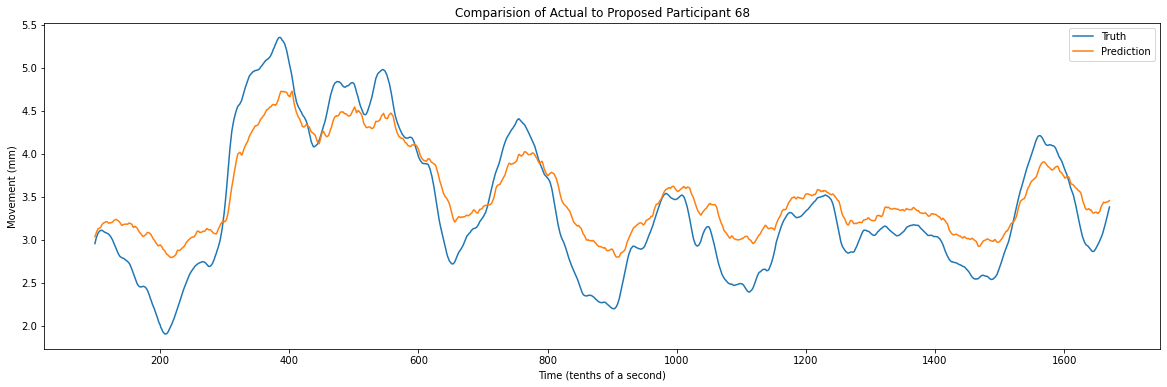

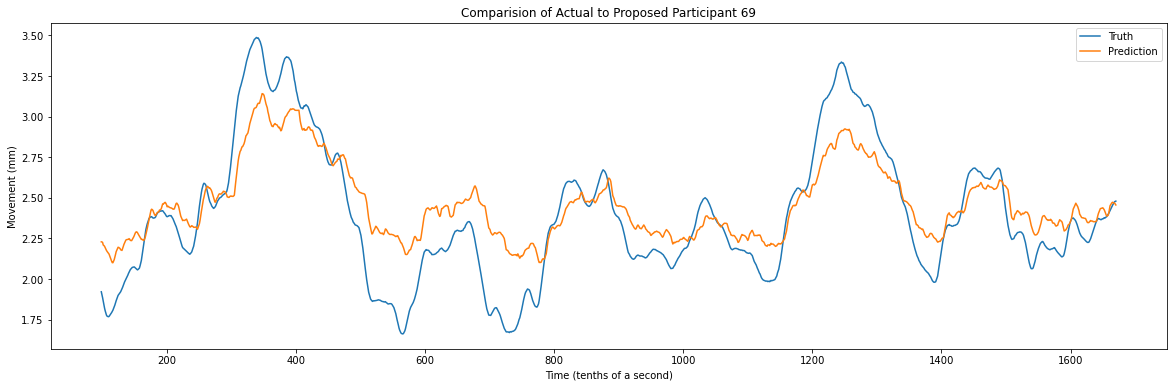

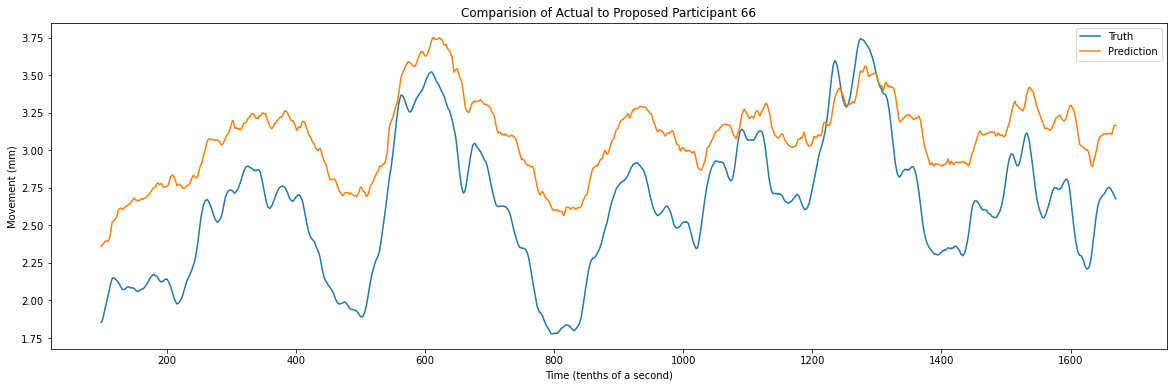

In [171]:
ind = 0
for par in test_y['PID'].unique():
    prediction = par_scores_df.loc[par_scores_df['par']==par, 'pred'][ind]
    truth = par_scores_df.loc[par_scores_df['par']==par, 'true'][ind]
    compare = pd.DataFrame({'Truth':truth, 'Prediction':prediction})
    compare.rolling(100).mean().plot(figsize=(20, 6))
    plt.title('Comparision of Actual to Proposed Participant {}'.format(par))
    plt.xlabel('Time (tenths of a second)')
    plt.ylabel('Movement (mm)')
    plt.show()
    ind +=1